In [123]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn

from sklearn.preprocessing import LabelEncoder
from sklearn.impute import KNNImputer

from sklearn.naive_bayes import GaussianNB, BernoulliNB
from sklearn.model_selection import train_test_split
from sklearn.multioutput import MultiOutputClassifier

from sklearn.metrics import roc_auc_score

In [124]:
vac_trainf = pd.read_csv('training_set_features.csv')
vac_trainf.shape

(26707, 36)

In [125]:
vac_trainf.columns

Index(['respondent_id', 'xyz_concern', 'xyz_knowledge',
       'behavioral_antiviral_meds', 'behavioral_avoidance',
       'behavioral_face_mask', 'behavioral_wash_hands',
       'behavioral_large_gatherings', 'behavioral_outside_home',
       'behavioral_touch_face', 'doctor_recc_xyz', 'doctor_recc_seasonal',
       'chronic_med_condition', 'child_under_6_months', 'health_worker',
       'health_insurance', 'opinion_xyz_vacc_effective', 'opinion_xyz_risk',
       'opinion_xyz_sick_from_vacc', 'opinion_seas_vacc_effective',
       'opinion_seas_risk', 'opinion_seas_sick_from_vacc', 'age_group',
       'education', 'race', 'sex', 'income_poverty', 'marital_status',
       'rent_or_own', 'employment_status', 'hhs_geo_region', 'census_msa',
       'household_adults', 'household_children', 'employment_industry',
       'employment_occupation'],
      dtype='object')

In [126]:
vac_trainf.dtypes

respondent_id                    int64
xyz_concern                    float64
xyz_knowledge                  float64
behavioral_antiviral_meds      float64
behavioral_avoidance           float64
behavioral_face_mask           float64
behavioral_wash_hands          float64
behavioral_large_gatherings    float64
behavioral_outside_home        float64
behavioral_touch_face          float64
doctor_recc_xyz                float64
doctor_recc_seasonal           float64
chronic_med_condition          float64
child_under_6_months           float64
health_worker                  float64
health_insurance               float64
opinion_xyz_vacc_effective     float64
opinion_xyz_risk               float64
opinion_xyz_sick_from_vacc     float64
opinion_seas_vacc_effective    float64
opinion_seas_risk              float64
opinion_seas_sick_from_vacc    float64
age_group                       object
education                       object
race                            object
sex                      

In [127]:
categorical = vac_trainf.loc[:,vac_trainf.dtypes == 'object']
print(categorical.columns)
for col in categorical.columns:
    print(len(categorical[col].unique()))

# nominal categorical - race, sex, marital_status, rent_or_own, employment_status, hhs_geo_region, census_msa
# ordinal categorical - age_group, education, income_poverty
nominalcategories = ['race', 'sex', 'marital_status', 'rent_or_own', 'employment_status', 'hhs_geo_region', 'census_msa']
ordinalcategories = ['age_group', 'education', 'income_poverty']

Index(['age_group', 'education', 'race', 'sex', 'income_poverty',
       'marital_status', 'rent_or_own', 'employment_status', 'hhs_geo_region',
       'census_msa', 'employment_industry', 'employment_occupation'],
      dtype='object')
5
5
4
2
4
3
3
4
10
3
22
24


In [128]:
def encode_missing_columns(df, col):
    le = LabelEncoder()
    
    # gets unique values w/o NaN
    unique_without_nan = pd.Series([i for i in df[col].unique() if type(i) == str])
    le.fit(unique_without_nan) # Fit on unique values
    
    # Set transformed col leaving np.NaN as they are
    df[col] = df[col].apply(lambda x: le.transform([x])[0] if type(x) == str else x)
    return le

In [129]:
def get_integer_mapping(le):
    """
    Return a dictionary mapping labels to their integer values.
    Args:
        le: A fitted SKlearn LabelEncoder instance.
    Returns:
        A dictionary where keys are labels and values are their corresponding integers.
    """
    res = {}
    for cl in le.classes_:
        res.update({cl: le.transform([cl])[0]})
    return res


In [130]:
labelencoders = []
for col in nominalcategories:
    labelencoders.append(encode_missing_columns(vac_trainf, col))

In [131]:
for col in ordinalcategories:
    print(vac_trainf[col].unique())

['55 - 64 Years' '35 - 44 Years' '18 - 34 Years' '65+ Years'
 '45 - 54 Years']
['< 12 Years' '12 Years' 'College Graduate' 'Some College' nan]
['Below Poverty' '<= $75,000, Above Poverty' '> $75,000' nan]


In [132]:
agemap = {'18 - 34 Years': 1, '35 - 44 Years': 2, '45 - 54 Years': 3, '55 - 64 Years': 4, '65+ Years': 5}
educationmap = {'< 12 Years': 1, '12 Years': 2, 'Some College': 3, 'College Graduate': 4}
income_povertymap = {'Below Poverty': 1, '<= $75,000, Above Poverty': 2, '> $75,000': 3}

vac_trainf['age_group'] = vac_trainf['age_group'].map(agemap)
vac_trainf['education'] = vac_trainf['education'].map(educationmap)
vac_trainf['income_poverty'] = vac_trainf['income_poverty'].map(income_povertymap)
vac_trainf.drop(['employment_occupation', 'employment_industry'], axis=1, inplace=True)
vac_trainf.set_index('respondent_id', inplace=True)

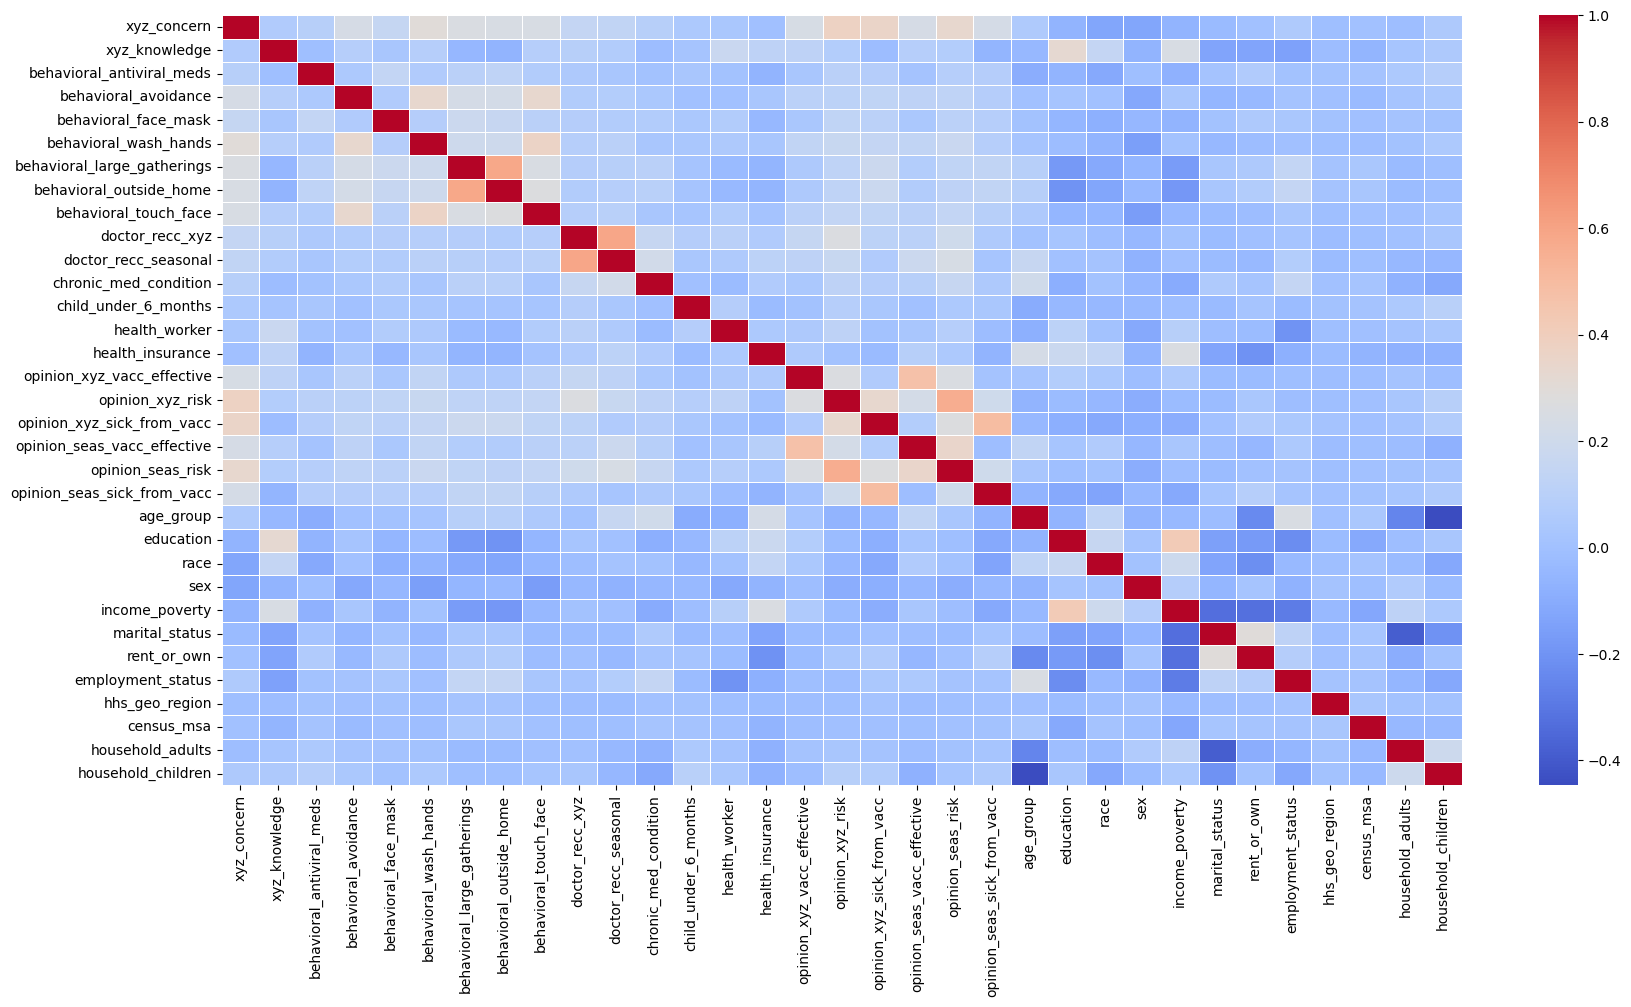

In [133]:
corr = vac_trainf.corr()
plt.figure(figsize=(20, 10))
sns.heatmap(corr, cmap='coolwarm', linewidths=0.5)
plt.show()

In [134]:
vac_trainf.drop(['behavioral_outside_home'], axis=1, inplace=True)

<Axes: ylabel='respondent_id'>

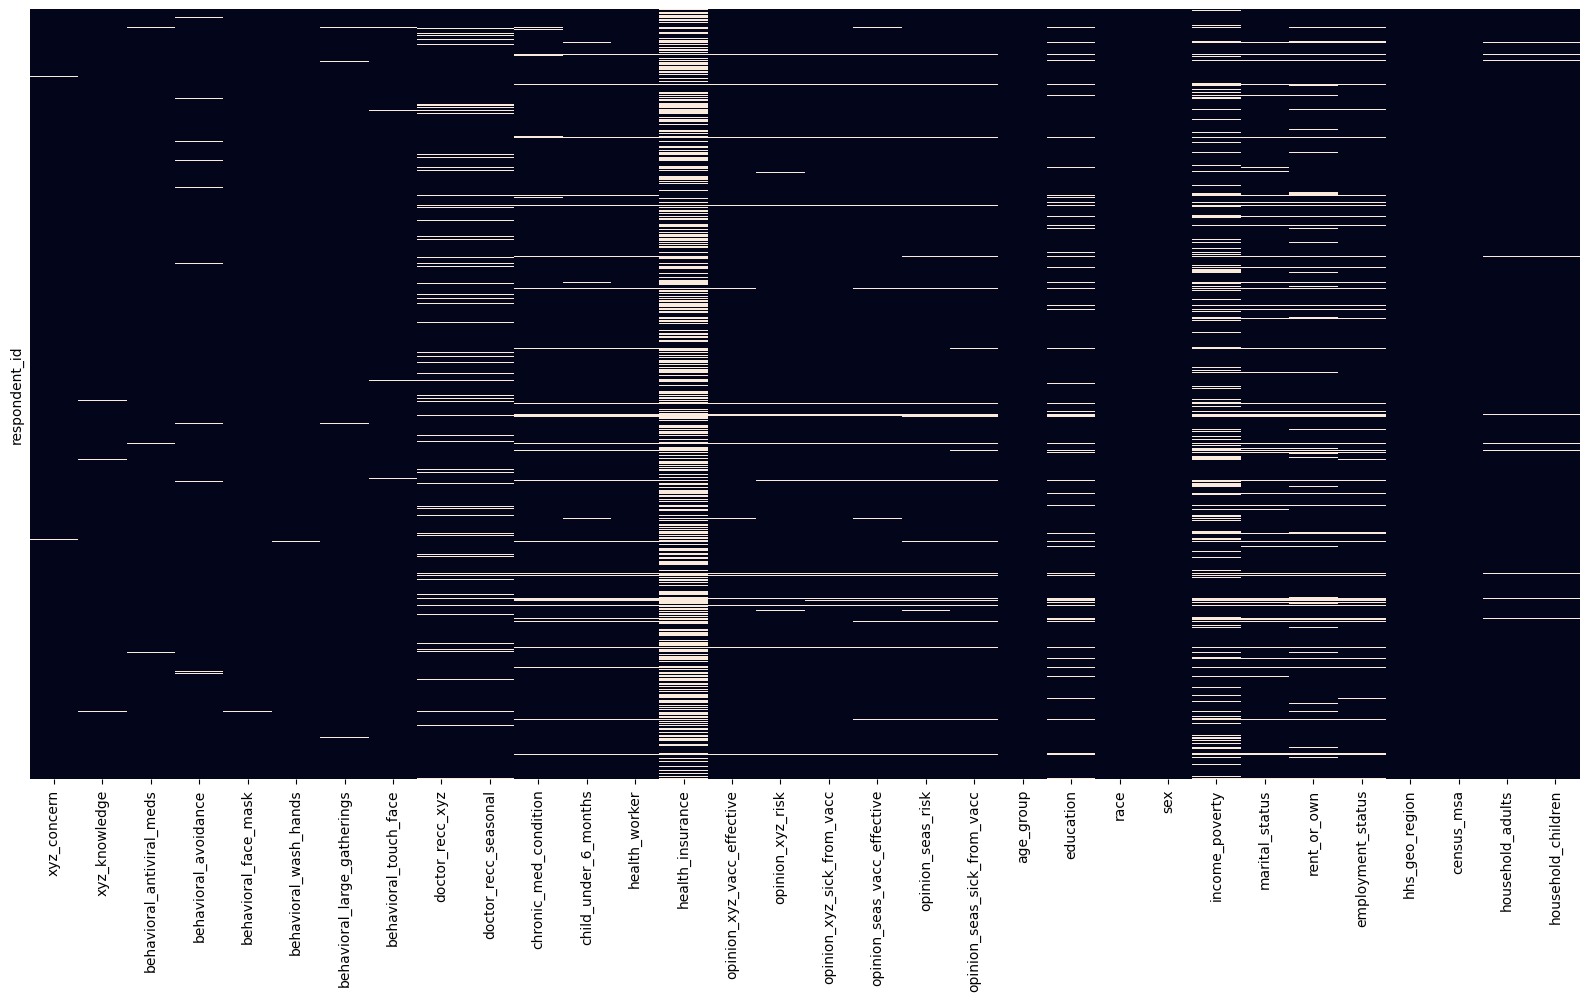

In [135]:
plt.figure(figsize=(20, 10))
sns.heatmap(vac_trainf.isnull(), yticklabels=False, cbar=False)

In [136]:
vac_trainf.isnull().sum()

xyz_concern                       92
xyz_knowledge                    116
behavioral_antiviral_meds         71
behavioral_avoidance             208
behavioral_face_mask              19
behavioral_wash_hands             42
behavioral_large_gatherings       87
behavioral_touch_face            128
doctor_recc_xyz                 2160
doctor_recc_seasonal            2160
chronic_med_condition            971
child_under_6_months             820
health_worker                    804
health_insurance               12274
opinion_xyz_vacc_effective       391
opinion_xyz_risk                 388
opinion_xyz_sick_from_vacc       395
opinion_seas_vacc_effective      462
opinion_seas_risk                514
opinion_seas_sick_from_vacc      537
age_group                          0
education                       1407
race                               0
sex                                0
income_poverty                  4423
marital_status                  1408
rent_or_own                     2042
e

In [137]:
knn_imputer = KNNImputer(n_neighbors=5)

vac_trainf = pd.DataFrame(knn_imputer.fit_transform(vac_trainf), columns=vac_trainf.columns, index=vac_trainf.index)


<Axes: ylabel='respondent_id'>

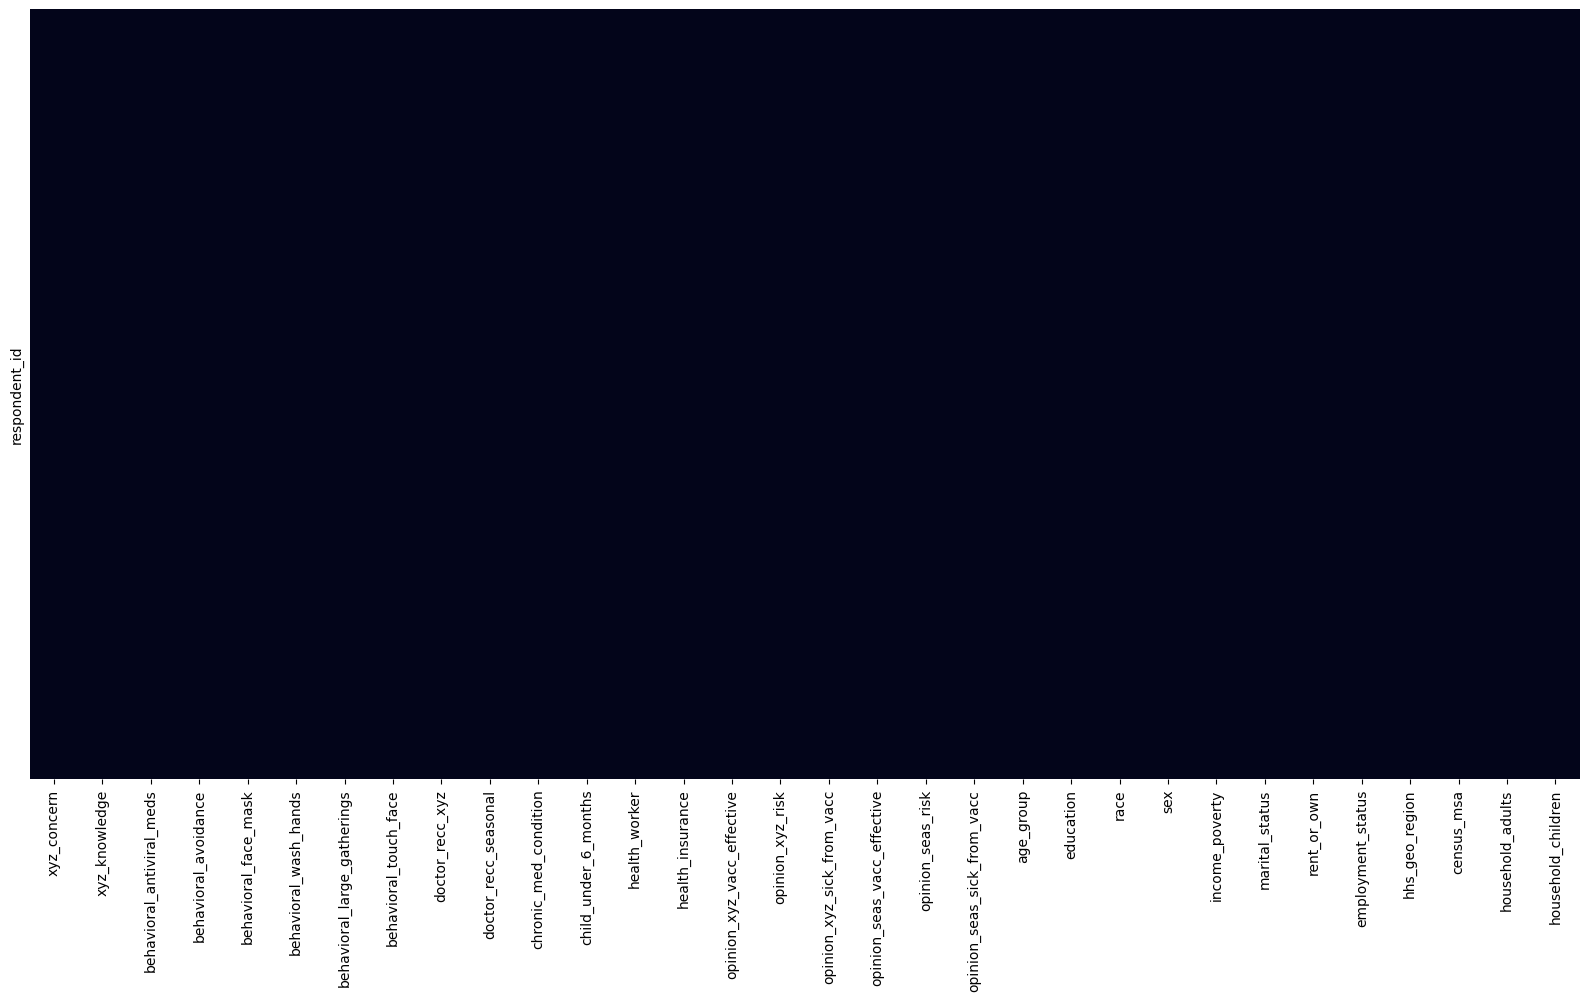

In [138]:
plt.figure(figsize=(20, 10))
sns.heatmap(vac_trainf.isnull(), yticklabels=False, cbar=False)

In [139]:
vac_trainl = pd.read_csv('training_set_labels.csv', index_col='respondent_id')
vac_trainl

,xyz_vaccine,seasonal_vaccine
respondent_id,,
0,0,0
1,0,1
2,0,0
3,0,1
4,0,0
...,...,...
26702,0,0
26703,0,0
26704,0,1


In [140]:
X_train, X_test, y_train, y_test = train_test_split(vac_trainf, vac_trainl, test_size=0.1, random_state=42)

# print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)
gnb = BernoulliNB()

mclf = MultiOutputClassifier(gnb)
mclf.fit(X_train, y_train)

mclf.fit(X_train, y_train)
proba = mclf.predict_proba(X_test)
predictions = mclf.predict(X_test)


yscore = np.concatenate([proba[0][:, 1], proba[1][:, 1]])
yscore = np.reshape(yscore, (len(proba[0]), 2))

y_true1 = y_test['xyz_vaccine']
y_true2 = y_test['seasonal_vaccine']
score1 = roc_auc_score(y_true=y_true1, y_score= yscore[:, 0], average='macro')
score2 = roc_auc_score(y_true=y_true2, y_score= yscore[:, 1], average='macro')

print(score1, score2)
print(predictions, y_test)
# print(proba)
# print(predictions)
# proba_array = np.array([p[:, 1] for p in proba]).T
# roc_auc_scores = []
# for i in range(y_test.shape[1]):
#     roc_auc = roc_auc_score(y_test[:, i], proba_array[:, i])
#     roc_auc_scores.append(roc_auc)
#     print(f"ROC AUC score for target variable {i+1}: {roc_auc:.4f}")

# # Calculate the average ROC AUC score
# average_roc_auc = np.mean(roc_auc_scores)
# print(f"\nAverage ROC AUC score: {average_roc_auc:.4f}")
# for i, probs in enumerate(proba):
#     print(f"Probabilities for target variable {i+1}:\n", probs)

# print("\nOriginal target values (y_test):\n", y_test)
# print("\nPredicted target values:\n", predictions)

0.5306568729031806 0.4965982151425007
[[0 1]
 [1 0]
 [0 1]
 ...
 [0 0]
 [0 1]
 [0 1]]                xyz_vaccine  seasonal_vaccine
respondent_id                               
15772                    0                 0
9407                     0                 1
16515                    0                 0
23353                    0                 0
10008                    0                 0
...                    ...               ...
24365                    0                 1
11773                    0                 0
24273                    0                 0
12908                    0                 1
11715                    0                 1

[2671 rows x 2 columns]


In [141]:
vac_test = pd.read_csv('test_set_features.csv')

numnom = len(nominalcategories)
for i in range(numnom):
    vac_test[nominalcategories[i]] = vac_test[nominalcategories[i]].apply(lambda x: labelencoders[i].transform([x])[0] if type(x) == str else x)

vac_test['age_group'] = vac_test['age_group'].map(agemap)
vac_test['education'] = vac_test['education'].map(educationmap)
vac_test['income_poverty'] = vac_test['income_poverty'].map(income_povertymap)
vac_test.drop(['employment_occupation', 'employment_industry'], axis=1, inplace=True)
vac_test.set_index('respondent_id', inplace=True)


In [142]:
vac_test.drop(['behavioral_outside_home'], axis=1, inplace=True)

In [143]:
vac_test = pd.DataFrame(knn_imputer.transform(vac_test), columns=vac_test.columns, index=vac_test.index)

<Axes: ylabel='respondent_id'>

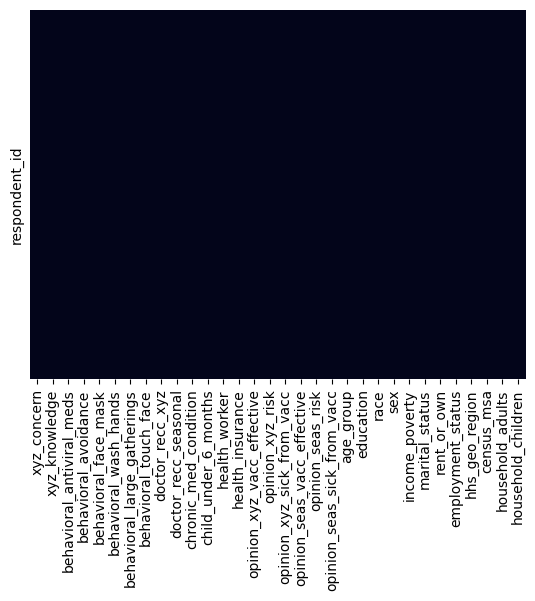

In [144]:
sns.heatmap(vac_test.isnull(), yticklabels=False, cbar=False)

In [151]:
proba_test = mclf.predict_proba(vac_test)

yscor_test = np.concatenate([proba_test[0][:, 1], proba_test[1][:, 1]])
yscore_test = np.reshape(yscor_test, (len(proba_test[0]), 2))

print(yscore_test)

[[0.08726943 0.01521948]
 [0.15746555 0.4333249 ]
 [0.22113977 0.22512623]
 ...
 [0.49789757 0.68590315]
 [0.12090531 0.05387763]
 [0.39572883 0.35662105]]


In [154]:
df = pd.DataFrame(yscore_test, columns=['xyz_vaccine', 'seasonal_vaccine'])
df['respondent_id'] = df.index
df = df[['respondent_id', 'xyz_vaccine', 'seasonal_vaccine']]

df.to_csv('output.csv', index=False)